# The Higgs Boson Machine Learning Challenge 
Brighton Nkomo

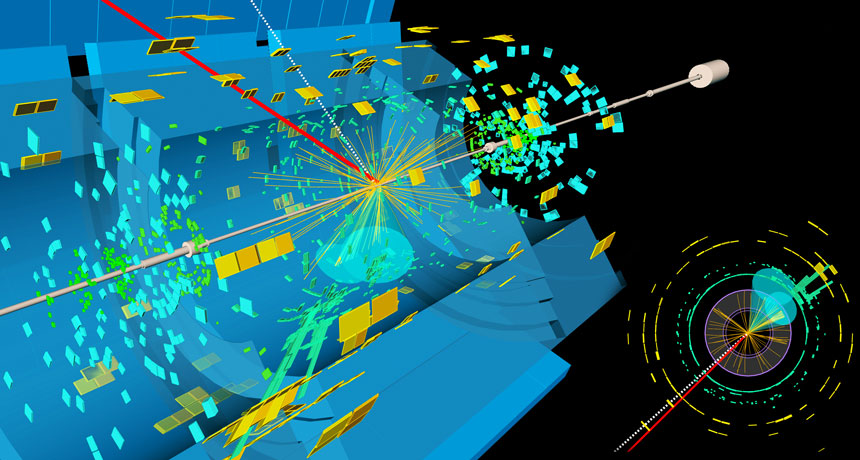

# Introduction 

The Higgs boson has many different processes through which it can decay. When it decays, it produces other particles. In physics, a decay into specific particles is called a _channel_. The Higgs boson has been seen first in three distinct decay channels which are all boson pairs. 

The dataset can be obtained from http://opendata.cern.ch/record/328 and has been built from official ATLAS full-detector simulation, with "Higgs to tautau" events mixed with different backgrounds. The simulator has two parts. In the first, random proton-proton collisions are simulated based on the knowledge that we have accumulated on particle physics. It reproduces the random microscopic explosions resulting from the proton-proton collisions. In the second part, the resulting particles are tracked through a virtual model of the detector. The process yields simulated events with properties that mimic the statistical properties of the real events with additional information on what has happened during the collision, before particles are measured in the detector.

The goal of this project is to essentially classify "tau tau decay of a Higgs boson" versus "background." So this is a binary classification issue and the desired metric to maximize is the _approximate median significance_ (AMS):

$$ \text{AMS} = \sqrt{2\left((s + b + b_r)\log \left( 1 + \frac{s}{b + b_r}\right) -s \right)}$$

where

\\(s, b\\): unnormalized true positive and false positive rates, respectively,
\\(b_r =10\\) is the constant regularization term,
\\(\log\\) is the natural log.
More precisely, let \\( y_1, \dotsc, y_n \in \{\text{b},\text{s}\}^n\\) be the vector of true test labels, let \\( \hat{y}_1, \dotsc, \hat{y}_n \in \{\text{b},\text{s}\}^n\\) be the vector of predicted _submitted_ test labels, and let \\( \in {\mathbb{R}^+}^n\\) be the vector of weights. Then

$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}$$

and

$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$

where the indicator function \\(\mathbb{1}\{A\}\\) is 1 if its argument \\(A\\) is true and 0 otherwise.

__NB:__ I have chosen to work with with the [__Log Loss__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) metric, which is one of the most important classification metrics based on probabilities. Although it's hard to interpret raw log-loss values, but log-loss is still a good metric for comparing models. _For any given problem, a lower log loss value means better predictions_. 

# Importing Relevant Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn import preprocessing
import utils

# suppress cell warnings
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [2]:
df = pd.read_csv('atlas-higgs-challenge-2014-v2.csv')

In [3]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


Variable Descriptions: 
- EventId - An unique integer identifier of the event.
- DER_mass_MMC - The estimated mass mH of the Higgs boson candidate, obtained through a probabilistic phase space integration.
- DER_mass_transverse_met_lep - The transverse mass between the missing transverse energy and the lepton.
- DER_mass_vis - The invariant mass of the hadronic tau and the lepton.
- DER_pt_h - The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton and the missing transverse energy vector.
- DER_deltaeta_jet_jet - The absolute value of the pseudorapidity separation between the two jets (undefined if PRI_jet_num ≤ 1).
- DER_mass_jet_jet - The invariant mass of the two jets (undefined if PRI_jet_num ≤ 1).
- DER_prodeta_jet_jet - The product of the pseudorapidities of the two jets (undefined if PRI_jet_num ≤ 1).
- DER_deltar_tau_lep - The R separation between the hadronic tau and the lepton.
- DER_pt_tot - The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥) and the subleading jet (if PRI jet num = 2) (but not of any additional jets).
- DER_sum_pt - The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num ≥ 1) and the subleading jet (if PRI jet num = 2) and the other jets (if PRI jet num = 3).
- DER_pt_ratio_lep_tau - The ratio of the transverse momenta of the lepton and the hadronic tau.
- DER_met_phi_centrality - The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.
- DER_lep_eta_centrality - The centrality of the pseudorapidity of the lepton w.r.t. the two jets (undefined if PRI_jet_num ≤ 1).
- PRI_tau_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the hadronic tau.
- PRI_tau_eta - The pseudorapidity $\eta$ of the hadronic tau.
- PRI_tau_phi - The azimuth angle $\phi$ of the hadronic tau.
- PRI_lep_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the lepton (electron or muon).
- PRI_lep_eta - The pseudorapidity $\eta$ of the lepton.
- PRI_lep_phi - The azimuth angle $\phi$ of the lepton.
- PRI_met - The missing transverse energy E→missT
- PRI_met_phi - The azimuth angle $\phi$ of the mssing transverse energy
- PRI_met_sumet - The total transverse energy in the detector.
- PRI_jet_num - The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3).
- PRI_jet_leading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is the jet with largest transverse momentum (undefined if PRI_jet_num = 0).
- PRI_jet_leading_eta - The pseudorapidity $\eta$ of the leading jet (undefined if PRI jet num = 0).
- PRI_jet_leading_phi - The azimuth angle $\phi$ of the leading jet (undefined if PRI jet num = 0).
- PRI_jet_subleading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is, the jet with second largest transverse momentum (undefined if PRI_jet_num ≤ 1).
- PRI_jet_subleading_eta - The pseudorapidity $\eta$ of the subleading jet (undefined if PRI_jet_num ≤ 1).
- PRI_jet_subleading_phi - The azimuth angle $\phi$ of the subleading jet (undefined if PRI_jet_num ≤ 1).
- PRI_jet_all_pt - The scalar sum of the transverse momentum of all the jets of the events.
- Weight - The event weight wi
- Label	The event label (string) yi ∈ {s,b} (s for signal, b for background).
- KaggleSet	- String specifying to which Kaggle set the event belongs : ”t”:training, ”b”:public leaderboard, ”v”:private leaderboard,”u”:unused.
- KaggleWeight - Weight normalised within each Kaggle dataset.

Since this notebook is not intended for the Kaggle competition, I will drop the KaggleSet and KaggleWeight columns.

In [4]:
df = df.drop(['KaggleSet', 'KaggleWeight'], axis=1)
if 'KaggleSet' and 'KaggleWeight' not in df.columns: print('yes')

yes


# Basic Insight of The Dataset

In [5]:
df.dtypes

EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta      

In [6]:
df.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,...,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,509118.500000,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,...,209.908730,0.979923,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594,0.503144
std,236205.109118,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,...,126.816686,0.978793,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754,0.572200
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000461
25%,304559.250000,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,...,122.985000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.005721
50%,509118.500000,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,...,179.883000,1.000000,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000,0.357223
75%,713677.750000,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,...,263.828000,2.000000,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000,0.733462
max,918237.000000,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,...,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316


In [62]:
#df.info

In [8]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

EventId
False    818238
Name: EventId, dtype: int64

DER_mass_MMC
False    818238
Name: DER_mass_MMC, dtype: int64

DER_mass_transverse_met_lep
False    818238
Name: DER_mass_transverse_met_lep, dtype: int64

DER_mass_vis
False    818238
Name: DER_mass_vis, dtype: int64

DER_pt_h
False    818238
Name: DER_pt_h, dtype: int64

DER_deltaeta_jet_jet
False    818238
Name: DER_deltaeta_jet_jet, dtype: int64

DER_mass_jet_jet
False    818238
Name: DER_mass_jet_jet, dtype: int64

DER_prodeta_jet_jet
False    818238
Name: DER_prodeta_jet_jet, dtype: int64

DER_deltar_tau_lep
False    818238
Name: DER_deltar_tau_lep, dtype: int64

DER_pt_tot
False    818238
Name: DER_pt_tot, dtype: int64

DER_sum_pt
False    818238
Name: DER_sum_pt, dtype: int64

DER_pt_ratio_lep_tau
False    818238
Name: DER_pt_ratio_lep_tau, dtype: int64

DER_met_phi_centrality
False    818238
Name: DER_met_phi_centrality, dtype: int64

DER_lep_eta_centrality
False    818238
Name: DER_lep_eta_centrality, dtype: int64

PRI_tau_

It appears that this dataset has no missing values since and the CERN scientists might have replaced them with an outlier, in particular -999, that is not in the range of the values of the provided features.

In [9]:
outlier_data = df.drop(['EventId'], axis=1)
for column in outlier_data.columns.values.tolist():
    print(column)
    print (df[column].loc[df[column] == -999].value_counts())
    print("") 

DER_mass_MMC
-999.0    124602
Name: DER_mass_MMC, dtype: int64

DER_mass_transverse_met_lep
Series([], Name: DER_mass_transverse_met_lep, dtype: int64)

DER_mass_vis
Series([], Name: DER_mass_vis, dtype: int64)

DER_pt_h
Series([], Name: DER_pt_h, dtype: int64)

DER_deltaeta_jet_jet
-999.0    580253
Name: DER_deltaeta_jet_jet, dtype: int64

DER_mass_jet_jet
-999.0    580253
Name: DER_mass_jet_jet, dtype: int64

DER_prodeta_jet_jet
-999.0    580253
Name: DER_prodeta_jet_jet, dtype: int64

DER_deltar_tau_lep
Series([], Name: DER_deltar_tau_lep, dtype: int64)

DER_pt_tot
Series([], Name: DER_pt_tot, dtype: int64)

DER_sum_pt
Series([], Name: DER_sum_pt, dtype: int64)

DER_pt_ratio_lep_tau
Series([], Name: DER_pt_ratio_lep_tau, dtype: int64)

DER_met_phi_centrality
Series([], Name: DER_met_phi_centrality, dtype: int64)

DER_lep_eta_centrality
-999.0    580253
Name: DER_lep_eta_centrality, dtype: int64

PRI_tau_pt
Series([], Name: PRI_tau_pt, dtype: int64)

PRI_tau_eta
Series([], Name: PRI_

Based on the summary above, each column has 818238 rows of data, eleven columns that were containing data replaced that has the outlier -999:
<ol>
    <li>"DER_mass_MMC": 124602 row values = -999</li>
    <li>"DER_deltaeta_jet_jet": 580253 row values = -999</li>
    <li>"DER_mass_jet_jet": 580253 row values = -999</li>
    <li>"DER_prodeta_jet_jet" : 580253 row values = -999</li>
    <li>"DER_lep_eta_centrality": 580253 row values = -999</li>
    <li>"PRI_jet_leading_pt": 327371 row values = -999</li>
    <li>"PRI_jet_leading_eta": 327371 row values = -999</li>
    <li>"PRI_jet_leading_phi": 327371 row values = -999</li>
    <li>"PRI_jet_subleading_pt": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_eta": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_phi": 580253 row values = -999</li>
</ol>

NB: For now, I will simply leave these outlier values in my data set.

# Data Visualization 

Now let's see how many rows are there labeled as 's' or 'b'. 

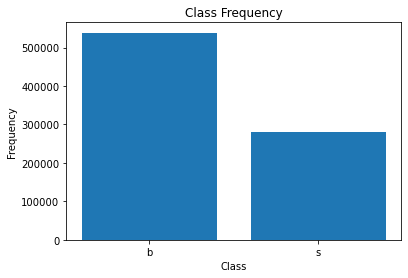

b    538678
s    279560
Name: Label, dtype: int64

In [10]:
unique, counts = np.unique(df['Label'], return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=['b','s'], labels=['b','s'])
#plt.ylim(top=300)

plt.show()
df['Label'].value_counts()

As we can see there are 538678 events labeled as background-b and 279560 events are labeled as signal-s. We clearly have a class inbalance; about a third of the data is the signal-s and the remaining two-thirds of the data is the background-b.

Let's take a look at the correlation between features.

In [11]:
# Calculate the correlation values
feature_cols = df.columns[:-1]
corr_values = df[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

Note that we are interested in the magnitude of the correlation between features, hence the reason why we should look at absolute correlations instead. In other words here, $\mid-0.8\mid = 0.8$. 

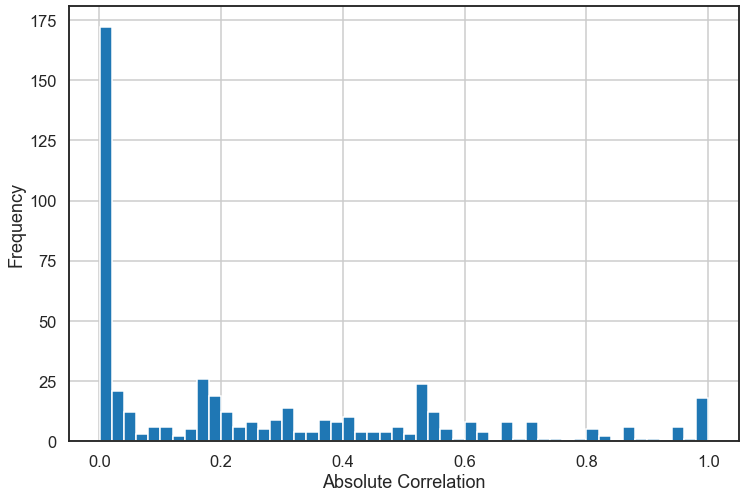

In [12]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

Most of the features have a zero correlation with other features. We are usually interested in features that are strongly correlated to each other or the target variable. Let's take a look at the features that are strongly correlated with each other next.

In [13]:
# The 10 most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8').head(10)

,feature1,feature2,correlation,abs_correlation
152,DER_deltaeta_jet_jet,DER_lep_eta_centrality,0.999998,0.999998
340,DER_lep_eta_centrality,PRI_jet_subleading_phi,0.999998,0.999998
339,DER_lep_eta_centrality,PRI_jet_subleading_eta,0.999997,0.999997
168,DER_deltaeta_jet_jet,PRI_jet_subleading_phi,0.999996,0.999996
167,DER_deltaeta_jet_jet,PRI_jet_subleading_eta,0.999995,0.999995
490,PRI_jet_subleading_eta,PRI_jet_subleading_phi,0.999995,0.999995
475,PRI_jet_leading_eta,PRI_jet_leading_phi,0.999992,0.999992
201,DER_prodeta_jet_jet,DER_lep_eta_centrality,0.999990,0.999990
217,DER_prodeta_jet_jet,PRI_jet_subleading_phi,0.999989,0.999989
216,DER_prodeta_jet_jet,PRI_jet_subleading_eta,0.999988,0.999988


In [14]:
corr_values.shape

(496, 4)

There are 496 pairs of features that show strong positive/negative correlation (i.e, absolute correlation vlaues greater than 0.8) 

# Pre-processing

In [15]:
set(df.Label)

{'b', 's'}

In [16]:
df['Class'] = utils.get_class_ids(df.Label.values)
set(df.Class)

{0, 1}

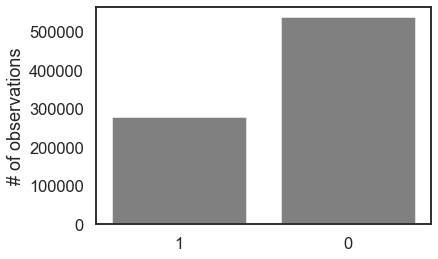

In [17]:
# Get all possible labels
labels = df.Class.unique()
heights = [len(df[df.Class==i]) for i in set(df.Class)] 
plt.bar(labels,heights,color='grey')
plt.xticks(labels,list(set(df.Class)))
plt.ylabel("# of observations")
plt.show()

# Model Building

In [18]:
features = list(set(df.columns) - {'Label', 'Class'})
features

['DER_sum_pt',
 'PRI_tau_eta',
 'PRI_lep_eta',
 'Weight',
 'DER_met_phi_centrality',
 'PRI_jet_leading_phi',
 'EventId',
 'PRI_tau_phi',
 'DER_mass_jet_jet',
 'PRI_jet_leading_eta',
 'DER_prodeta_jet_jet',
 'DER_pt_ratio_lep_tau',
 'DER_mass_vis',
 'PRI_lep_phi',
 'DER_mass_transverse_met_lep',
 'PRI_jet_all_pt',
 'PRI_lep_pt',
 'DER_pt_h',
 'PRI_met_phi',
 'DER_deltaeta_jet_jet',
 'DER_pt_tot',
 'PRI_jet_subleading_phi',
 'PRI_jet_subleading_eta',
 'DER_deltar_tau_lep',
 'DER_mass_MMC',
 'PRI_met_sumet',
 'DER_lep_eta_centrality',
 'PRI_tau_pt',
 'PRI_jet_subleading_pt',
 'PRI_jet_leading_pt',
 'PRI_jet_num',
 'PRI_met']

In [19]:
df.Label.values

array(['s', 'b', 'b', ..., 'b', 'b', 'b'], dtype=object)

### Dividing the data into two parts

Since we have an imbalanced dataset, I'll use a stratified shuffle split to maintain the same ratio of classes in the train and validation data.

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.1, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[features], df.Class))

# Create the dataframes
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'Class']

X_test  = df.loc[test_idx, features]
y_test  = df.loc[test_idx, 'Class']

In [21]:
len(X_train), len(X_test)

(736414, 81824)

In [22]:
#training_data, validation_data = train_test_split(df, random_state=11, train_size=0.10)

In [23]:
#len(training_data), len(validation_data)

### Sklearn Classifiers

Now let's look at which model performs best at classifying events in the validation sample. I will seperate this section into 2 parts:
- 1. Linear and non-linear models 
- 2. Tree-based models

### 1. Linear Model: 
#### 1.1 Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [26]:
%%time
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

Wall time: 13min 4s


In [27]:
%%time
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

Wall time: 12min 3s


In [28]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,1,1,1
1,1,0,1
2,0,1,0
3,0,1,0
4,0,0,0


In [29]:
y_prob.head()

,lr,l1,l2
0,0.529365,0.999952,0.529295
1,0.850536,1.000000,0.850076
2,0.930755,0.999940,0.930898
3,0.623456,0.999992,0.623457
4,0.946619,1.000000,0.946688


In [57]:
log_loss(y_test, y_pred['l1'])

9.99200722162641e-16

In [33]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [34]:
metrics

,lr,l1,l2
precision,0.725109,1.0,0.725044
recall,0.734931,1.0,0.734870
fscore,0.718818,1.0,0.718717
accuracy,0.734931,1.0,0.734870
auc,0.665014,1.0,0.664882


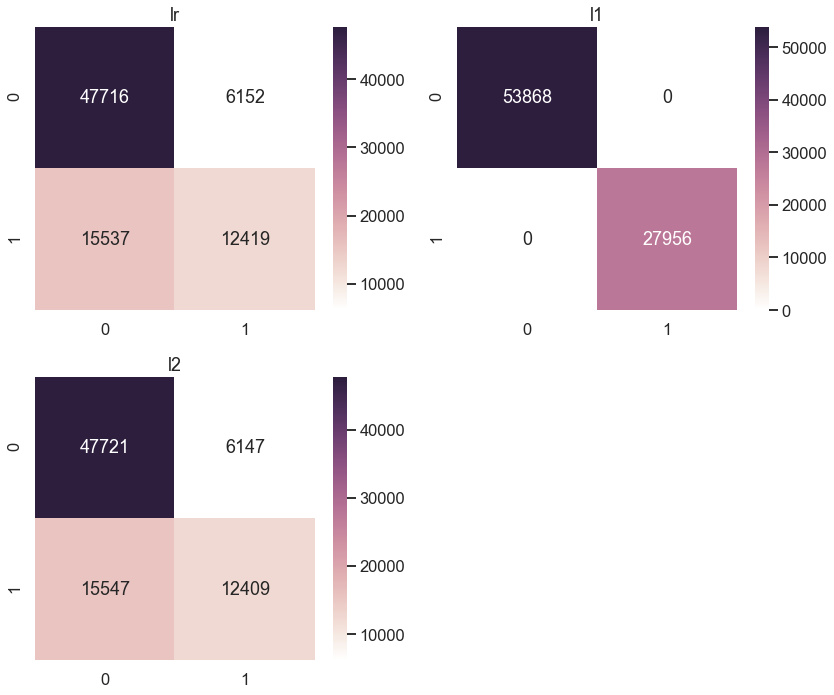

In [42]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=cmap);
    ax.set(title=lab);
    
plt.tight_layout()

The linear regression model using the L1-regularization technique, also called Lasso Regression, clearly outpeforms the other two models.

### 2. Tree-Based Model: Boosted Decision Tree

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

In [59]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, subsample=0.3, random_state=13,
                                min_samples_leaf=10, max_depth=30)
gb.fit(X_train, y_train)

Wall time: 54min 54s


GradientBoostingClassifier(learning_rate=0.05, max_depth=30,
                           min_samples_leaf=10, n_estimators=1000,
                           random_state=13, subsample=0.3)

In [60]:
# predict each event
proba_gb = gb.predict_proba(X_test)

In [76]:
gb_pred = gb.predict(X_test)

In [61]:
log_loss(y_test, proba_gb)

9.99200722162641e-16

### 3. Keras Neural Network 

In [64]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

In [65]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [67]:
nn = nn_model(len(features))
nn.fit(X_train, np_utils.to_categorical(y_train), verbose=1, epochs=10, batch_size=256)

Epoch 1/10
2877/2877 [==============================] - 11s 3ms/step - loss: 0.6430
Epoch 2/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6429
Epoch 3/10
2877/2877 [==============================] - 8s 3ms/step - loss: 0.6428
Epoch 4/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6428
Epoch 5/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6427
Epoch 6/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6428
Epoch 7/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6427
Epoch 8/10
2877/2877 [==============================] - 9s 3ms/step - loss: 0.6428
Epoch 9/10
2877/2877 [==============================] - 6s 2ms/step - loss: 0.6428
Epoch 10/10
2877/2877 [==============================] - 8s 3ms/step - loss: 0.6428


### Log loss on the cross validation sample

In [69]:
# predict each event
proba_nn = nn.predict(X_test)

In [70]:
log_loss(y_test, proba_nn)

0.6954471773665003

NB: this neural network still needs some tuning, it's just a baseline model and a quick check that all is working well in Keras.

# Quality Metrics

Now I'll plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [98]:
proba = proba_nn

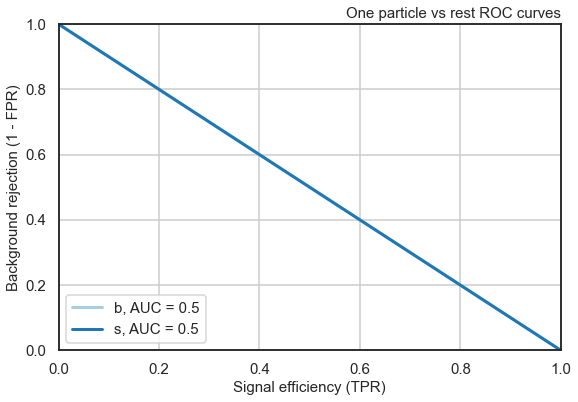

In [99]:
utils.plot_roc_curves(proba, y_test)

In [ ]:
import os
import csv
import math


def create_solution_dictionary(solution):
    """ Read solution file, return a dictionary with key EventId and value (weight,label).
    Solution file headers: EventId, Label, Weight """
    
    solnDict = {}
    with open(solution, 'rb') as f:
        soln = csv.reader(f)
        soln.next() # header
        for row in soln:
            if row[0] not in solnDict:
                solnDict[row[0]] = (row[1], row[2])
    return solnDict

        
def check_submission(submission, Nelements):
    """ Check that submission RankOrder column is correct:
        1. All numbers are in [1,NTestSet]
        2. All numbers are unqiue
    """
    rankOrderSet = set()    
    with open(submission, 'rb') as f:
        sub = csv.reader(f)
        sub.next() # header
        for row in sub:
            rankOrderSet.add(row[1])
            
    if len(rankOrderSet) != Nelements:
        print 'RankOrder column must contain unique values'
        exit()
    elif rankOrderSet.isdisjoint(set(xrange(1,Nelements+1))) == False:
        print 'RankOrder column must contain all numbers from [1..NTestSset]'
        exit()
    else:
        return True

    
def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print 'radicand is negative. Exiting'
        exit()
    else:
        return math.sqrt(radicand)


def AMS_metric(solution, submission):
    """  Prints the AMS metric value to screen.
    Solution File header: EventId, Class, Weight
    Submission File header: EventId, RankOrder, Class
    """
    
    numEvents = 550000 # number of events = size of test set
    
    # solutionDict: key=eventId, value=(label, class)
    solutionDict = create_solution_dictionary(solution)

    signal = 0.0
    background = 0.0
    if check_submission(submission, numEvents):
        with open(submission, 'rb') as f:
            sub = csv.reader(f)
            sub.next() # header row
            for row in sub:
                if row[2] == 's': # only events predicted to be signal are scored
                    if solutionDict[row[0]][0] == 's':
                        signal += float(solutionDict[row[0]][1])
                    elif solutionDict[row[0]][0] == 'b':
                        background += float(solutionDict[row[0]][1])
     
        print 'signal = {0}, background = {1}'.format(signal, background)
        print 'AMS = ' + str(AMS(signal, background))


if __name__ == "__main__":

    # enter path and file names here    
    path = ""
    solutionFile = ""
    submissionFile = ""
    
    AMS_metric(solutionFile, submissionFile)

In [ ]:
def ams(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print 'radicand is negative. Exiting'
        exit()
    else:
        return math.sqrt(radicand)
    
def AMS_metric(y_true, y_pred):
    """  Prints the AMS metric value to screen.
    """
    signal = 0.0
    background = 0.0
    for i in y_pred:
        for j in y_true:
            if i == 1 : # only events predicted to be signal are scored
                if j==1:
                    signal += float(solutionDict[row[0]][1])
                elif solutionDict[row[0]][0] == 'b':
                    background += float(solutionDict[row[0]][1])
     
        print 'signal = {0}, background = {1}'.format(signal, background)
        print 'AMS = ' + str(AMS(signal, background))

In [ ]:
def logloss(true_label, predicted_prob):
    if true_label == 1:
        return -np.log(predicted_prob)
    else:
        return -np.log(1 - predicted_prob)